In [161]:
import numpy as np
import EFIE as solve
light_speed, mu0, eps0 = 299792458., 4*np.pi*1e-7, 8.854e-12

frequency = 1e6 * 146
omega, wavelength = 2 * np.pi * frequency, light_speed / frequency
incident_field, radius = 220, 3.175e-3
delta_r = wavelength / 100

class yagi:
    def __init__(self, position, angle, length, source_position, radius):
        self.position = position
        self.angle = angle
        self.length = length
        self.source_position = source_position
        self.radius = radius

class tree:
    def __init__(self, its, phi, length, f, radius, field):
        self.its = its
        self.phi = phi
        self.length = length
        self.f = f
        self.radius = radius
        self.field = field

basis_functions = 'triangle'
structure_type = 'yagi-uda'
position = np.array([[0.0, 0.0, 0.0]])
angle = np.array([[np.pi/2, 0]])
length = np.array([delta_r*50])
source_position = np.array([[0.0, 0.0, 0.0, incident_field]])
radii = np.array([radius])
test_yagi = yagi(position, angle, length, source_position, radii)

In [ ]:
I,R = solve.calc_current_amplitudes(structure_type,basis_functions,test_yagi,frequency,delta_r)

In [ ]:
E,angles = solve.calc_field_pattern(0,0,basis_functions,structure_type,test_yagi,I,R,delta_r,frequency)
print(np.abs(E))

In [ ]:
import numpy as np 
from scipy import linalg 
import scipy.integrate as integrate 
from tqdm import tqdm
import geometry as gm
import matrix_elements as matrix_elements

# define constants

light_speed, mu0, eps0 = 299792458., 4*np.pi*1e-7, 8.854e-12
c = light_speed

def basis_func(basis_functions, t_n, r_n, dr_n):
    if basis_functions == 'pulse' :
        return 1
    elif basis_functions == 'triangle':
        if -1/2 <= t_n <= 1/2 :
            return 1/2 + t_n
        elif 1/2 <= t_n <= 3/2 :
            return 3/2 - t_n

def weight_func(basis_functions, t_m, r_m, dr_m):
    if basis_functions == 'pulse' :
        return 1
    elif basis_functions == 'triangle':
        if -1/2 <= t_m <= 1/2 :
            return 1/2 + t_m
        elif 1/2 <= t_m <= 3/2 :
            return 3/2 - t_m

def exp_dp_real (t_m, point, r_m, dr_m, omega, basis_functions):
    k = omega/c
    rmn = np.linalg.norm(point - r_m - dr_m * (t_m - 1/2))
    f_m = weight_func(basis_functions=basis_functions, t_m=t_m, r_m=r_m, dr_m=dr_m)
    return f_m * np.cos(-k * rmn)

def exp_dp_imag (t_m, point, r_m, dr_m, omega, basis_functions):
    k = omega/c
    rmn = np.linalg.norm(point - r_m - dr_m * (t_m - 1/2))
    f_m = weight_func(basis_functions=basis_functions, t_m=t_m, r_m=r_m, dr_m=dr_m)
    return f_m * np.sin(-k * rmn)

def calc_field_pattern_new (phi, theta, basis_functions, structure_type, antenna, current, R, delta_r, frequency) :

    omega = 2 * np.pi * frequency
    
    v = np.array([np.sin(theta) * np.cos(phi), np.sin(theta) * np.sin(phi), np.cos(theta)])
    aux_v = np.array([1, 0, 0])
    perp_v1 = np.cross(v, aux_v) / np.linalg.norm(np.cross(v, aux_v))
    perp_v2 = np.cross(perp_v1, v) / np.linalg.norm(np.cross(perp_v1, v))

    Radius, num_points = 1e2, 100
    angles = np.linspace(0, 2 * np.pi, num_points)

    points = np.zeros((num_points, 3))
    for i, angle in enumerate(angles):
        points[i] = Radius * (np.cos(angle) * perp_v1 + np.sin(angle) * perp_v2)

    segments_block, source_segments = gm.antenna_to_segments(structure_type='yagi-uda', antenna=antenna, basis_functions='triangle', delta_r=delta_r)
    dr_n = delta_r * segments_block[0][0].tau
    if basis_functions == 'pulse_optimized':
        E = []
        k = 2 * np.pi * frequency / light_speed
        for point in points:
            E_i = 0
            for j in range(len(R)):
                rmn = np.linalg.norm(point - R[j])
                k_vec = point - R[j] / rmn
                k_p = np.dot(k_vec, dr_n)
                if k_p == 0:
                    E_i += - 1j*omega*mu0*current[j]*delta_r/(2*np.pi*rmn) * np.exp(-1j*k*rmn)
                else:
                    E_i += - 1j* omega * mu0 * current[j] * delta_r / (4 * np.pi * rmn * k_p**2) * np.exp(-1j*k*rmn) * np.exp(-1j*k_p)*(2*np.exp(1j*k_p) - np.exp(2j*k_p)-1)
            E.append(E_i)
        E_total = np.abs(E)
        return E_total, angles
    
    
    return E_total, angles

In [ ]:
E_new, angles = calc_field_pattern_new(0,0,'pulse_optimized', structure_type,test_yagi,I,R,delta_r,frequency)

In [ ]:
print((E_new/E))

In [ ]:
import matplotlib.pyplot as plt 
plt.polar(angles,E, label = 'exact solution')
plt.polar(angles,E_new, label = 'analit')
plt.legend()

In [162]:
import geometry as gm
import matrix_elements as matrix_elements

segments_block, source_segments = gm.antenna_to_segments(structure_type=structure_type, antenna=test_yagi, basis_functions=basis_functions, delta_r=delta_r)
impedance_past = matrix_elements.calculate_impedance(basis_functions=basis_functions, structure_type=structure_type, segments_block=segments_block, frequency=frequency, delta_r=delta_r)

In [163]:
c, mu0, eps0 = 299792458., 4*np.pi*1e-7, 8.854e-12

def basis_func(basis_functions, t_n, r_n, dr_n):
    if basis_functions == 'pulse' :
        return 1
    elif basis_functions == 'triangle':
        if -1/2 <= t_n <= 1/2 :
            return 1/2 + t_n
        elif 1/2 <= t_n <= 3/2 :
            return 3/2 - t_n

def weight_func(basis_functions, t_m, r_m, dr_m):
    if basis_functions == 'pulse' :
            return 1
    elif basis_functions == 'triangle':
            if -1/2 <= t_m <= 1/2 :
                return 1/2 + t_m
            elif 1/2 <= t_m <= 3/2 :
                return 3/2 - t_m
            
def impedance_real (t_m, t_n, r_m, r_n, dr_m, dr_n, omega, basis_functions):
    k = omega / c
    
    tau_n = dr_n / np.linalg.norm(dr_n)
    tau_m = dr_m / np.linalg.norm(dr_m)
    
    c_0 = (np.dot(tau_m, tau_n))
    c_x = (1/k**2 * tau_n[0] * tau_m[0])
    c_y = (1/k**2 * tau_n[1] * tau_m[1])
    c_z = (1/k**2 * tau_n[2] * tau_m[2])
    c_xy = (1/k**2 * (tau_m[0]*tau_n[1] + tau_m[1]*tau_n[0]))
    c_xz = (1/k**2 * (tau_m[0]*tau_n[2] + tau_m[2]*tau_n[0]))
    c_yz = (1/k**2 * (tau_m[1]*tau_n[2] + tau_m[2]*tau_n[1]))

    sum_c = (c_x + c_y + c_z + c_xy + c_xz + c_yz)

    rmn =  (np.linalg.norm(r_m - r_n + dr_m*(t_m-1/2) - dr_n*(t_n-1/2)))
    dx = (r_m[0] - r_n[0] + dr_m[0]*(t_m-1/2) - dr_n[0]*(t_n-1/2))
    dy = (r_m[1] - r_n[1] + dr_m[1]*(t_m-1/2) - dr_n[1]*(t_n-1/2))
    dz = (r_m[2] - r_n[2] + dr_m[2]*(t_m-1/2) - dr_n[2]*(t_n-1/2))
    psi = c_x * dx**2 + c_y * dy**2 + c_z * dz**2 + c_xy * dx * dy + c_xz * dx * dz + c_yz * dy * dz

    
    polypart1 = c_0 * rmn**2 - sum_c - psi * (k**2 * rmn**2 + 1) / rmn**2
    polypart2 = -k * (rmn * sum_c + psi/rmn)
    
    f_n = basis_func(basis_functions=basis_functions, t_n=t_n, r_n=r_n, dr_n=dr_n)
    f_m = weight_func(basis_functions=basis_functions, t_m=t_m, r_m=r_m, dr_m=dr_m)
    
    return f_n * f_m * (polypart1 * np.cos(k * rmn) + polypart2 * np.sin(k * rmn)) / rmn**3
    
def impedance_imag (t_m, t_n, r_m, r_n, dr_m, dr_n, omega, basis_functions):
    k = omega / c
    
    tau_n = dr_n / np.linalg.norm(dr_n)
    tau_m = dr_m / np.linalg.norm(dr_m)
    
    c_0 = (np.dot(tau_m, tau_n))
    c_x = (1/k**2 * tau_n[0] * tau_m[0])
    c_y = (1/k**2 * tau_n[1] * tau_m[1])
    c_z = (1/k**2 * tau_n[2] * tau_m[2])
    c_xy = (1/k**2 * (tau_m[0]*tau_n[1] + tau_m[1]*tau_n[0]))
    c_xz = (1/k**2 * (tau_m[0]*tau_n[2] + tau_m[2]*tau_n[0]))
    c_yz = (1/k**2 * (tau_m[1]*tau_n[2] + tau_m[2]*tau_n[1]))

    sum_c = (c_x + c_y + c_z + c_xy + c_xz + c_yz)

    rmn =  (np.linalg.norm(r_m - r_n + dr_m*(t_m-1/2) - dr_n*(t_n-1/2)))
    dx = (r_m[0] - r_n[0] + dr_m[0]*(t_m-1/2) - dr_n[0]*(t_n-1/2))
    dy = (r_m[1] - r_n[1] + dr_m[1]*(t_m-1/2) - dr_n[1]*(t_n-1/2))
    dz = (r_m[2] - r_n[2] + dr_m[2]*(t_m-1/2) - dr_n[2]*(t_n-1/2))
    psi = c_x * dx**2 + c_y * dy**2 + c_z * dz**2 + c_xy * dx * dy + c_xz * dx * dz + c_yz * dy * dz
    
    polypart1 = c_0 * rmn**2 - sum_c - psi * (k**2 * rmn**2 + 1) / rmn**2
    polypart2 = -k * (rmn * sum_c + psi/rmn)
    
    f_n = basis_func(basis_functions=basis_functions, t_n=t_n, r_n=r_n, dr_n=dr_n)
    f_m = weight_func(basis_functions=basis_functions, t_m=t_m, r_m=r_m, dr_m=dr_m)
    
    return f_n * f_m * (-polypart1 * np.sin(k * rmn) + polypart2 * np.cos(k * rmn)) / rmn**3

def self_impedance_real (t_m, t_n, r_m, r_n, dr_m, dr_n, omega, basis_functions):
    k = omega / c
    
    tau_n = dr_n / np.linalg.norm(dr_n)
    tau_m = dr_m / np.linalg.norm(dr_m)
    
    c_0 = (np.dot(tau_m, tau_n))
    c_x = (1/k**2 * tau_n[0] * tau_m[0])
    c_y = (1/k**2 * tau_n[1] * tau_m[1])
    c_z = (1/k**2 * tau_n[2] * tau_m[2])
    c_xy = (1/k**2 * (tau_m[0]*tau_n[1] + tau_m[1]*tau_n[0]))
    c_xz = (1/k**2 * (tau_m[0]*tau_n[2] + tau_m[2]*tau_n[0]))
    c_yz = (1/k**2 * (tau_m[1]*tau_n[2] + tau_m[2]*tau_n[1]))

    sum_c = (c_x + c_y + c_z + c_xy + c_xz + c_yz)

    rmn =  (np.linalg.norm(r_m - r_n + dr_m*(t_m-1/2) - dr_n*(t_n-1/2)))
    dx = (r_m[0] - r_n[0] + dr_m[0]*(t_m-1/2) - dr_n[0]*(t_n-1/2))
    dy = (r_m[1] - r_n[1] + dr_m[1]*(t_m-1/2) - dr_n[1]*(t_n-1/2))
    dz = (r_m[2] - r_n[2] + dr_m[2]*(t_m-1/2) - dr_n[2]*(t_n-1/2))
    psi = c_x * dx**2 + c_y * dy**2 + c_z * dz**2 + c_xy * dx * dy + c_xz * dx * dz + c_yz * dy * dz
    
    polypart1 = c_0 / rmn - sum_c / rmn ** 3 + 3 * psi / rmn**5
    polypart2 = -k * c_0
    
    f_n = basis_func(basis_functions=basis_functions, t_n=t_n, r_n=r_n, dr_n=dr_n)
    f_m = weight_func(basis_functions=basis_functions, t_m=t_m, r_m=r_m, dr_m=dr_m)
    
    return f_n * f_m * polypart1
    
def self_impedance_imag (t_m, t_n, r_m, r_n, dr_m, dr_n, omega, basis_functions):
    k = omega / c
    
    tau_n = dr_n / np.linalg.norm(dr_n)
    tau_m = dr_m / np.linalg.norm(dr_m)
    
    c_0 = (np.dot(tau_m, tau_n))
    c_x = (1/k**2 * tau_n[0] * tau_m[0])
    c_y = (1/k**2 * tau_n[1] * tau_m[1])
    c_z = (1/k**2 * tau_n[2] * tau_m[2])
    c_xy = (1/k**2 * (tau_m[0]*tau_n[1] + tau_m[1]*tau_n[0]))
    c_xz = (1/k**2 * (tau_m[0]*tau_n[2] + tau_m[2]*tau_n[0]))
    c_yz = (1/k**2 * (tau_m[1]*tau_n[2] + tau_m[2]*tau_n[1]))

    sum_c = (c_x + c_y + c_z + c_xy + c_xz + c_yz)

    rmn =  (np.linalg.norm(r_m - r_n + dr_m*(t_m-1/2) - dr_n*(t_n-1/2)))
    dx = (r_m[0] - r_n[0] + dr_m[0]*(t_m-1/2) - dr_n[0]*(t_n-1/2))
    dy = (r_m[1] - r_n[1] + dr_m[1]*(t_m-1/2) - dr_n[1]*(t_n-1/2))
    dz = (r_m[2] - r_n[2] + dr_m[2]*(t_m-1/2) - dr_n[2]*(t_n-1/2))
    psi = c_x * dx**2 + c_y * dy**2 + c_z * dz**2 + c_xy * dx * dy + c_xz * dx * dz + c_yz * dy * dz
    
    polypart1 = c_0 / rmn - sum_c / rmn ** 3 + 3 * psi / rmn**5
    polypart2 = -k * c_0
    
    f_n = basis_func(basis_functions=basis_functions, t_n=t_n, r_n=r_n, dr_n=dr_n)
    f_m = weight_func(basis_functions=basis_functions, t_m=t_m, r_m=r_m, dr_m=dr_m)
    
    return f_n * f_m * polypart2


In [164]:
import numpy as np 
from scipy import linalg 
import scipy.integrate as integrate 
from tqdm import tqdm
rtol = 1e-6
def calculate_impedance_opt (basis_functions, structure_type, segments_block, frequency, delta_r):
    
    omega = 2 * np.pi * frequency
    
    element_num = []
    for i in range (len(segments_block)):
        element_num.append(len(segments_block[i]))
    element_num = np.array(element_num)
    
    impedance_block = []
    
    if structure_type == 'yagi-uda':    
        for m in range(len(segments_block)):
            impedance_row = []
            for n in range(len(segments_block)):
                impedance_mn = np.zeros((len(segments_block[m]), len(segments_block[n])), dtype=complex)
                if m <= n :
                    for i in range (len(segments_block[m]) + len(segments_block[n])):
                        impedance_mn[max(0, len(segments_block[m])-i-1), max(0, i-len(segments_block[m]))] = Zmn(structure_type=structure_type,basis_functions=basis_functions, m=m, n=n, i=max(0, len(segments_block[m])-i-1), j=max(0, i-len(segments_block[m])), segments_block=segments_block, omega=2*np.pi*frequency, delta_r=delta_r)
                        for k in range (min( min(len(segments_block[m]), len(segments_block[n])), i+1, len(segments_block[m]) + len(segments_block[n]) - i)):
                            impedance_mn[max(0, len(segments_block[m])-i-1) + k, max(0, i-len(segments_block[m])) + k] = impedance_mn[max(0, len(segments_block[m])-i-1), max(0, i-len(segments_block[m]))]
                else :
                    impedance_mn = impedance_block[n][m].T
                impedance_row.append(impedance_mn)   
            impedance_block.append(impedance_row)
    
    num_elements = sum(element_num)
    impedance = np.zeros((num_elements, num_elements), dtype = complex)
    cum_n = np.append(0, np.cumsum(element_num))
    for i in range (len(cum_n)-1):
        for j in range (len(cum_n)-1):
            impedance[cum_n[i]:cum_n[i+1], cum_n[j]:cum_n[j+1]] = impedance_block[i][j]
    return impedance

def Zmn (structure_type, basis_functions, m, n, i, j, segments_block, omega, delta_r):

    if basis_functions == 'pulse' :
        t_min, t_max = 0, 1
    elif basis_functions == 'triangle' :
        t_min, t_max = -1/2, 3/2
        
    a_m = segments_block[m][i].radius
    a_n = segments_block[n][j]. radius
    
    tau_m = segments_block[m][i].tau
    tau_n = segments_block[n][j].tau
    
    r_m = segments_block[m][i].position 
    r_n = segments_block[n][j].position 
    
    if structure_type == 'yagi-uda':
        r_n = r_n + a_n * np.array([0,0,1])
    elif structure_type == 'tree':
        r_n = r_n + a_n * np.array([0,0,1])

    dr_m = delta_r * tau_m
    dr_n = delta_r * tau_n
    if m == n and i == j:
       return 1j*omega*mu0 / (4*np.pi) * delta_r **2 * (integrate.dblquad(self_impedance_real, t_min, t_max, lambda z1: t_min, lambda z2: t_max, args=(r_m, r_n, dr_m, dr_n, omega, basis_functions))[0] + 1j * integrate.dblquad(self_impedance_imag, t_min, t_max, lambda z1: t_min, lambda z2: t_max, args=(r_m, r_n, dr_m, dr_n, omega, basis_functions))[0])
    return 1j*omega*mu0 / (4*np.pi) * delta_r **2 * (integrate.dblquad(impedance_real, t_min, t_max, lambda z1: t_min, lambda z2: t_max, args=(r_m, r_n, dr_m, dr_n, omega, basis_functions))[0] + 1j * integrate.dblquad(impedance_imag, t_min, t_max, lambda z1: t_min, lambda z2: t_max, args=(r_m, r_n, dr_m, dr_n, omega, basis_functions))[0])

In [165]:
impedance = calculate_impedance_opt(basis_functions=basis_functions, structure_type=structure_type, segments_block=segments_block, frequency=frequency, delta_r=delta_r)

In [166]:
print(impedance[0].real/impedance_past[0].real)

[ 1.50024162 -0.81837917 -0.98296101 -0.99401881 -0.99683795 -0.99803617
 -0.9986627  -0.99903273 -0.99926986 -0.99943107 -0.99954568 -0.99963009
 -0.99969405 -0.99974366 -0.99978291 -0.99981448 -0.99984024 -0.99986152
 -0.99987928 -0.99989426 -0.99990698 -0.99991788 -0.99992726 -0.99993539
 -0.99994247 -0.99994866 -0.99995409 -0.99995887 -0.99996308 -0.9999668
 -0.9999701  -0.99997301 -0.9999756  -0.99997788 -0.99997989 -0.99998166
 -0.99998321 -0.99998456 -0.99998573 -0.99998672 -0.99998755 -0.99998823
 -0.99998877 -0.99998917 -0.99998944 -0.99998958 -0.99998959 -0.99998948
 -0.99998923 -0.99998885]


In [167]:
print((impedance[0].imag/impedance_past[0].imag))

[  0.99940537 -14.0803394   -1.05596962  -1.00400841  -1.00174026
  -1.00098099  -1.00062124  -1.00042072  -1.0002977   -1.00021733
  -1.00016247  -1.00012383  -1.00009598  -1.00007557  -1.00006041
  -1.00004907  -1.00004054  -1.00003409  -1.00002923  -1.00002557
  -1.00002283  -1.0000208   -1.00001932  -1.00001827  -1.00001755
  -1.00001709  -1.00001684  -1.00001675  -1.00001678  -1.00001693
  -1.00001716  -1.00001748  -1.00001787  -1.00001834  -1.00001889
  -1.00001955  -1.00002035  -1.00002135  -1.00002263  -1.00002436
  -1.00002685  -1.00003075  -1.00003774  -1.00005387  -1.00012888
  -0.99986776  -0.99996714  -0.99998508  -0.99999242  -0.99999629]


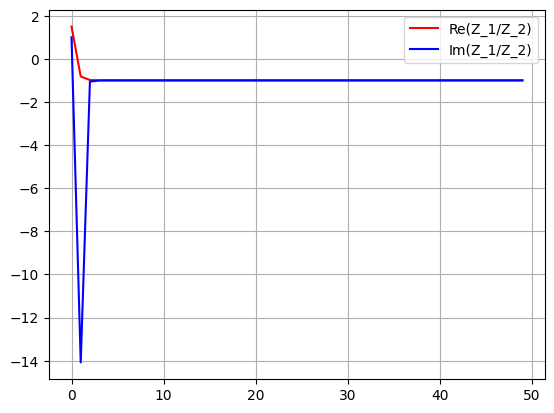

In [168]:
import matplotlib.pyplot as plt 

plt.plot(impedance[0].real/impedance_past[0].real, 'r-', label = 'Re(Z_1/Z_2)')
plt.plot((impedance[0].imag / impedance_past[0].imag), 'b-', label = 'Im(Z_1/Z_2)')
#plt.plot(impedance[0].imag, 'r--', label = '$\\mathrm{Im}\\left(Z_{\\mathrm{new}}\\right)$')
#plt.plot(impedance_past[0].imag, 'b--', label = '$\\mathrm{Im}\\left(Z_{\\mathrm{prev}}\\right)$')
plt.legend()
plt.grid()
#plt.xscale('log')
#plt.yscale('log')